## Simple Neural Network for MNIST Classification

* Fully connected network with L2 regularization
* 1 hidden layer with 100 nodes

## Imports

In [6]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time

## Get MNIST Data

In [7]:
import mnist

data_train = mnist.train_images()
data_test = mnist.test_images()

labels_train = mnist.train_labels()
labels_test= mnist.test_labels()

## Prepare data

In [10]:
# X_train.shape = (784, 60000)
# X_test.shape  = (784, 10000)
# Y_train.shape = (10, 60000)
# Y_test.shape  = (10, 10000)

k = 10

m_train, n, _ = data_train.shape
m_test, _, _ = data_test.shape 

normalize = lambda v: v/255 - 0.5

X_train = normalize(data_train.reshape(m_train, n**2).T)
X_test = normalize(data_test.reshape(m_test, n**2).T)

Y_train = np.eye(k)[labels_train].T
Y_test = np.eye(k)[labels_test].T

## Define functions

In [32]:
def random_mini_batches(X, Y, minibatch_size, seed):
    
    np.random.seed(seed)
    
    _, m = X.shape
    
    indices = np.array([i for i in range(m)])
    
    np.random.shuffle(indices)
    
    X = X[:, indices]
    Y = Y[:, indices]
    
    minibatches = []
    i = 0
    
    while i < m:
        
        minibatches.append((X[:, i:i+minibatch_size], Y[:, i:i+minibatch_size]))
        i += minibatch_size
    
    return minibatches

def create_placeholders(n_0, k):
    
    X = tf.placeholder(tf.float32, shape = [n_0, None], name = "X")
    Y = tf.placeholder(tf.float32, shape = [k, None], name = "Y")
    
    return X, Y

def initialize_params(n_0, n_1, k):
    
    tf.set_random_seed(1)
    
    W1 = tf.get_variable("W1", [n_1, n_0], dtype = tf.float32, initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable("b1", [n_1, 1], dtype = tf.float32, initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [k, n_1], dtype = tf.float32, initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable("b2", [k, 1], dtype = tf.float32, initializer = tf.zeros_initializer())
    
    
    params = {
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2
    }
                        
    return params

def forward_propagate(X, params):
    
    # W1.shape = (n_1, n_0)
    # b1.shape = (n_1, 1)
    # W2.shape = (k, n_1)
    # b2.shape = (k, 1)
    
    W1 = params["W1"]
    b1 = params["b1"]
    W2 = params["W2"]
    b2 = params["b2"]

    n_0 = tf.shape(W1)[1]
    n_1 = tf.shape(W1)[0]
    k = tf.shape(W2)[0]
    
    Z1 = tf.tensordot(W1, X, [[1], [0]]) + b1
    A1 = tf.nn.relu(Z1)
    Z2 = tf.tensordot(W2, Z1, [[1], [0]]) + b2
    
    return Z2

def get_cost(Y, Z2, params, beta=0):
    
    # Y.shape = (k, m)
    # Z2.shape = (k, m)
    
    W1 = params["W1"]
    W2 = params["W2"]
    
    logits = tf.transpose(Z2)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    cost += beta * (tf.reduce_mean(tf.nn.l2_loss(W1)) + tf.reduce_mean(tf.nn.l2_loss(W2)))
    
    return cost

# ##### -------------------------------------------------------- #####

def model(X_train, 
          Y_train, 
          X_test, 
          Y_test,
          n_1 = 100,
          learning_rate = 0.0001,
          beta = 0.01,
          num_epochs = 1500, 
          minibatch_size = 32, 
          print_cost = True):
    
    # X_train.shape = (n, m)
    # Y_train.shape = (k, m)
    
    tf.reset_default_graph()
    
    tf.set_random_seed(1)
    seed = 2
    
    (n_0, m) = X_train.shape
    k = Y_train.shape[0]
    J_train = []
    J_valid = []
    
    X, Y = create_placeholders(n_0, k)
    params = initialize_params(n_0, n_1, k)
    Z2 = forward_propagate(X, params)
    J = get_cost(Y, Z2, params, beta)
    
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(J)

    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        
        sess.run(init)
        
        tic = time()
        
        for epoch in range(num_epochs):

            epoch_cost = 0
            num_minibatches = int(m / minibatch_size)
            seed += 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            
            for minibatch in minibatches:

                (minibatch_X, minibatch_Y) = minibatch
                _ , minibatch_cost = sess.run([optimizer, J], feed_dict={X: minibatch_X, Y: minibatch_Y})
                epoch_cost += minibatch_cost / num_minibatches
            
            if print_cost == True and epoch % 10 == 0:
                dt = time() - tic
                print ("Cost after epoch %i: %f (time elapsed = %f s)" % (epoch, epoch_cost, dt))
                
            if epoch % 2 == 0:
                J_train.append(epoch_cost)
                J_valid.append(sess.run(J, feed_dict = {X: X_test, Y: Y_test}))
        
        font = {"family": "Century Gothic", "weight": "normal", "size" : 14}
        plt.rc("font", **font)
        fig = plt.figure(figsize = (10, 7))
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(np.squeeze(J_train), label = "J_train")
        ax.plot(np.squeeze(J_valid), label = "J_valid")
        ax.legend()
        ax.set_xlim([0, len(J_train)])
        ax.set_ylabel("Cost", fontdict = {"fontsize": 16, "weight": "bold"})
        ax.set_xlabel("Iteration", fontdict = {"fontsize": 16, "weight": "bold"})
        ax.set_title("Learning Rate = %g" % learning_rate,
                     fontdict = {"fontsize": 24, "weight": "bold"})
        plt.show()
        
        params = sess.run(params)
        
        correct_pred = tf.equal(tf.argmax(Z2), tf.argmax(Y))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, "float"))
        
        acc_train = sess.run(accuracy, feed_dict = {X: X_train, Y: Y_train})
        acc_test = sess.run(accuracy, feed_dict = {X: X_test, Y: Y_test})
        
        print("Training complete.")
        
        return (params, acc_train, acc_test, J_train, J_valid)

Cost after epoch 0: 0.728715 (time elapsed = 2.682678 s)
Cost after epoch 10: 0.358666 (time elapsed = 31.151110 s)
Cost after epoch 20: 0.332993 (time elapsed = 61.271550 s)
Cost after epoch 30: 0.321559 (time elapsed = 90.259979 s)


/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Century Gothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


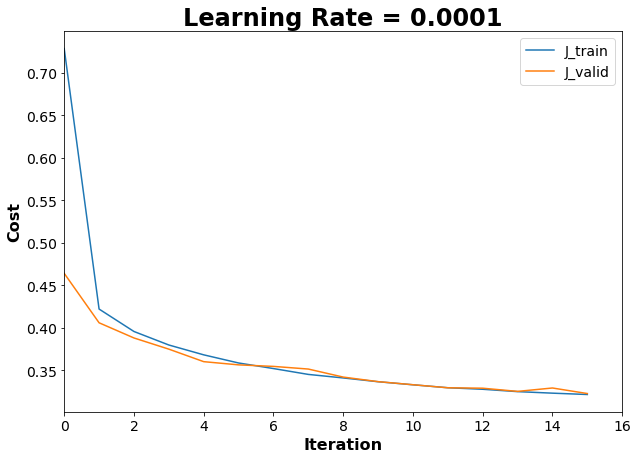

Training complete.


In [37]:
result = model(X_train, 
               Y_train, 
               X_test, 
               Y_test,
               n_1 = 100,
               learning_rate = 0.0001,
               beta = 0.001,
               num_epochs = 31, 
               minibatch_size = 32, 
               print_cost = True)

In [38]:
params, acc_train, acc_test, J_train, J_valid = result

print("Train Accuracy: %f" % acc_train)
print(" Test Accuracy: %f" % acc_test)

Train Accuracy: 0.926217
 Test Accuracy: 0.921400


## Visualize W1 weights

In [63]:
12*9

108

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Century Gothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


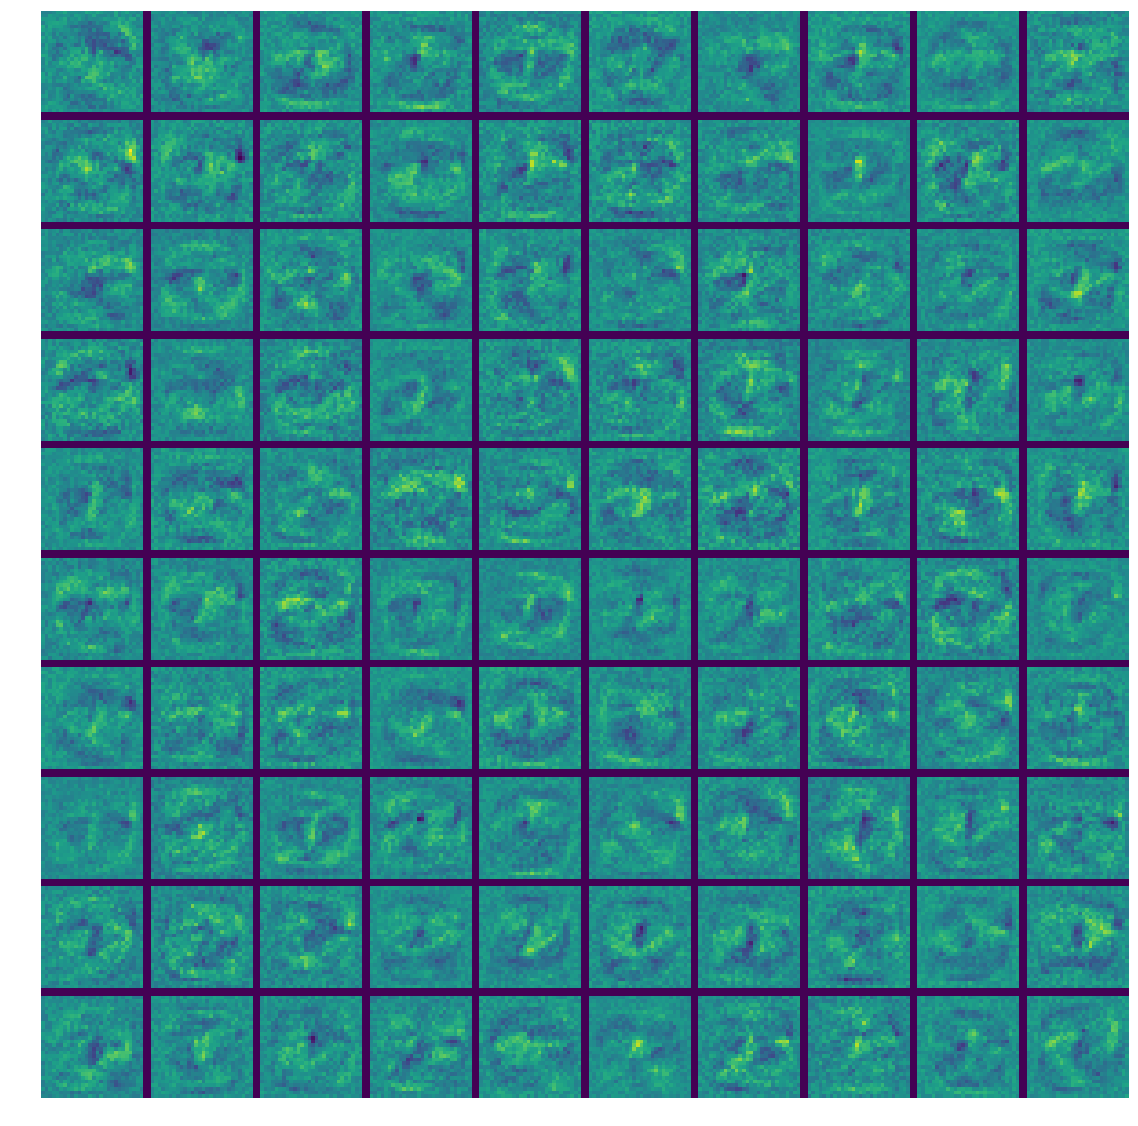

In [72]:
def prepare_weights(W1, buffer=2, w=10):

    n_1 = W1.shape[0]
    h = int(np.ceil(n_1/w))
    
    height = 28*h + buffer * (h - 1)
    width = 28*w + buffer * (w - 1)
    M = np.zeros([height, width])

    neuron = 0
    row = 0


    while row < h:

        col = 0

        while col < w and neuron < n_1:

            i_start = row * (28 + buffer)
            i_stop = i_start + 28
            j_start = col * (28 + buffer)
            j_stop = j_start + 28

            M[i_start:i_stop, j_start:j_stop] = W1[neuron, :].reshape(28, 28)

            col += 1
            neuron += 1

        row += 1
    
    return M

##### ------------------------------------------ #####

W1 = params["W1"] - np.min(params["W1"])

M = prepare_weights(W1, buffer = 2, w = 10)

fig = plt.figure(figsize = (20, 20))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(M)
ax.axis("off")
plt.show()